<a href="https://colab.research.google.com/github/aml-spring-19/homework-5-ds3731_lh2916_hw5/blob/master/Homework5_Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 3

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import glob, zipfile, imageio, fnmatch, cv2, random
import keras
from keras.layers import (Conv2D, MaxPooling2D,
                         Flatten, Dense, Activation,
                         BatchNormalization, Input, add)
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

Using TensorFlow backend.


In [0]:
np.random.seed(seed=42)

## Loading in the data using Kaggle API

In [0]:
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"cccccali","key":"56abaf9a6a6f96332143c2ec4c687af6"}'}

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

 99% 1.47G/1.49G [00:21<00:00, 83.7MB/s]
100% 1.49G/1.49G [00:21<00:00, 73.4MB/s]


In [0]:
zip_ref = zipfile.ZipFile('/content/breast-histopathology-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

zip_ref = zipfile.ZipFile('/content/IDC_regular_ps50_idx5.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Process images

In [0]:
# Get shape of image
im = cv2.imread('../content/10253/0/10253_idx5_x1001_y1001_class0.png')
image_size = im.shape
print(image_size)

(50, 50, 3)


In [0]:
filenames = glob.glob('../content/**/*.png', recursive=True)
n_imgs = len(filenames)
filenames[0:5]

['../content/9077/1/9077_idx5_x1151_y901_class1.png',
 '../content/9077/1/9077_idx5_x2501_y1251_class1.png',
 '../content/9077/1/9077_idx5_x651_y1451_class1.png',
 '../content/9077/1/9077_idx5_x2351_y751_class1.png',
 '../content/9077/1/9077_idx5_x1901_y2001_class1.png']

In [0]:
# Function to plot image with color
def plotImage(image_name):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (50,50))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return


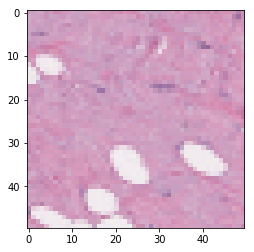

In [0]:
# Test plot an image
test_img = filenames[0]
plotImage(test_img)

Split filenames into 2 classes

In [0]:
class0_ending = '*class0.png'
class1_ending = '*class1.png'
class_0 = np.array(fnmatch.filter(filenames, class0_ending))
class_1 = np.array(fnmatch.filter(filenames, class1_ending))
print("Non-IDC (Class 0): ",len(class_0),'\n')
print("IDC (Class 1): ",len(class_1))

Non-IDC (Class 0):  198738 

IDC (Class 1):  78786


Process each class of filenames into arrays

In [0]:
X_0 = np.array([cv2.resize(cv2.imread(x), (50, 50), 
                           interpolation=cv2.INTER_CUBIC) for x in class_0])
y_0 = np.repeat(0, X_0.shape[0])

In [0]:
X_1 = np.array([cv2.resize(cv2.imread(x), (50, 50), 
                           interpolation=cv2.INTER_CUBIC) for x in class_1])
y_1 = np.repeat(1, X_1.shape[0])

## Using subsamples (used this when testing code)

In [0]:
class0_size = X_0.shape[0]
class0_subsample_size = int(class0_size * .8)
print(class0_size)
print(class0_subsample_size)

class0_idx = np.random.choice(class0_size, class0_subsample_size)
X_0_subsample = X_0[class0_idx]
y_0_subsample = y_0[class0_idx]

198738
158990


In [0]:
class1_size = X_1.shape[0]
class1_subsample_size = int(class1_size * .8)
print(class1_size)
print(class1_subsample_size)

class1_idx = np.random.choice(class1_size, class1_subsample_size)
class1_subsample = X_1[class1_idx]
X_1_subsample = X_1[class1_idx]
y_1_subsample = y_1[class1_idx]

78786
63028


In [0]:
X_subsample = np.concatenate((X_0_subsample, X_1_subsample))
y_subsample = np.concatenate((y_0_subsample, y_1_subsample))
print(X_subsample.shape)
print(y_subsample.shape)

(222018, 50, 50, 3)
(222018,)


**Splitting into training set, validation set, and test set**

In [0]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X_subsample, y_subsample,
                                                          test_size=0.2,
                                                          stratify=y_subsample,
                                                          random_state=42,
                                                          )
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval,
                                                  test_size=0.1,
                                                  stratify=y_trainval,
                                                  random_state=42,
                                                  )

## Using full data

In [0]:
X = np.concatenate((X_0, X_1))
y = np.concatenate((y_0, y_1))
print(X.shape)
print(y.shape)

(277524, 50, 50, 3)
(277524,)


In [0]:
np.save("X_all.npy", X)
np.save("y_all.npy", y)

In [0]:
X = np.load("X_all.npy")
y = np.load("y_all.npy")

**Splitting into training set, validation set, and test set**

In [0]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y,
                                                          test_size=0.2,
                                                          stratify=y,
                                                          random_state=42,
                                                          )
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval,
                                                  test_size=0.1,
                                                  stratify=y_trainval,
                                                  random_state=42,
                                                  )

In [0]:
# Training, Validation, and Test Set
# Ratios of class 0 and class 1 and Shapes
print('Training Set: ')
print('Shape: ', X_train.shape)
print(pd.DataFrame(y_train)[0].value_counts(), '\n')

print('Validation Set: ')
print('Shape: ', X_val.shape)
print(pd.DataFrame(y_val)[0].value_counts(), '\n')

print('Test Set: ')
print('Shape: ', X_test.shape)
print(pd.DataFrame(y_test)[0].value_counts())

Training Set: 
Shape:  (199817, 50, 50, 3)
0    143091
1     56726
Name: 0, dtype: int64 

Validation Set: 
Shape:  (22202, 50, 50, 3)
0    15899
1     6303
Name: 0, dtype: int64 

Test Set: 
Shape:  (55505, 50, 50, 3)
0    39748
1    15757
Name: 0, dtype: int64


###**Balancing the training set**

You can see that this is an imbalanced dataset, with many more class 0 than class 1. Therefore, I am going to balance the training set, and keep the validation and test set imbalanced to accuractely imitate the classification problem at hand.

In order to use imblearn's RandomUnderSampler, the shape of the inputs have to be flat, so we flatten the training set, balance it, and then reshape it back to the right shape of (n_samples, 50, 50, 3)

In [0]:
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)

rus = RandomUnderSampler(random_state=42)
X_train_rus_flat, y_train_rus = rus.fit_sample(X_trainFlat, y_train)

# Balanced Training Set Ratio
print('Training Set: ')
print('Shape: ', X_train_rus_flat.shape)
print(pd.DataFrame(y_train_rus)[0].value_counts())

Training Set: 
Shape:  (113452, 7500)
1    56726
0    56726
Name: 0, dtype: int64


Rehaping back to (50, 50, 3) for each in X_train

In [0]:
X_train_rus = X_train_rus_flat.reshape(len(X_train_rus_flat),
                                       X_train.shape[1],
                                       X_train.shape[2],
                                       X_train.shape[3])

We shuffle the training set because it was ordered with all class 0 first and then all class 1after that.

In [0]:
from sklearn.utils import shuffle
X_train_rus, y_train_rus = shuffle(X_train_rus, y_train_rus)

print(X_train_rus.shape)
print(y_train_rus.shape)


(113452, 50, 50, 3)
(113452,)


Encoding categorical y labels as 2 binary columns

In [0]:
# OHE y variable to use softmax
n_classes = 2
y_train_rus_ohe = keras.utils.to_categorical(y_train_rus, n_classes)
y_test_ohe = keras.utils.to_categorical(y_test, n_classes)
y_val_ohe = keras.utils.to_categorical(y_val, n_classes)

In [0]:
# Delete variables to save RAM
# del y_train_rus, y_test, y_val, X_train, X_trainShape, X_trainFlat, X_train_rus_flat, X, y

Plot image again to make sure it wasn't garbled

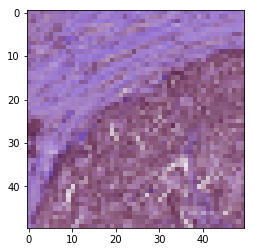

In [0]:
plt.imshow(X_train_rus[0])
plt.show()

# 3.1
**Baseline CNN**

In [0]:
input_shape = X_train_rus.shape[1:]
n_classes = 2
input_shape = X_train_rus.shape[1:]

cnn_model = Sequential()

# 1st layer
cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                     input_shape=input_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation("relu"))

cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd layer
cnn_model.add(Conv2D(32, (3, 3)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation("relu"))

cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd layer
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))

# output layer, output dimension = number of classes
cnn_model.add(Dense(n_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 22, 22, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 22, 22, 32)        0         
__________

In [0]:
cnn_model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

In [0]:
cnn = cnn_model.fit(X_train_rus, y_train_rus_ohe,
                    batch_size=32,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_val, y_val_ohe))

Instructions for updating:
Use tf.cast instead.
Train on 113452 samples, validate on 22202 samples
Epoch 1/10
113452/113452 [==============================] - 29s 256us/step - loss: 0.4002 - acc: 0.8283 - val_loss: 0.3754 - val_acc: 0.8425
Epoch 2/10
113452/113452 [==============================] - 24s 210us/step - loss: 0.3681 - acc: 0.8431 - val_loss: 0.4802 - val_acc: 0.7529
Epoch 3/10
113452/113452 [==============================] - 25s 217us/step - loss: 0.3538 - acc: 0.8510 - val_loss: 0.3681 - val_acc: 0.8548
Epoch 4/10
113452/113452 [==============================] - 24s 208us/step - loss: 0.3447 - acc: 0.8546 - val_loss: 0.4347 - val_acc: 0.7998
Epoch 5/10
113452/113452 [==============================] - 24s 207us/step - loss: 0.3362 - acc: 0.8582 - val_loss: 0.3819 - val_acc: 0.8635
Epoch 6/10
113452/113452 [==============================] - 24s 210us/step - loss: 0.3308 - acc: 0.8600 - val_loss: 0.3833 - val_acc: 0.8434
Epoch 7/10
113452/113452 [=============================

In [0]:
def plot_history(logger):
    df = pd.DataFrame(logger.history)
    df[['acc', 'val_acc']].plot()
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.title("Neural network training results")

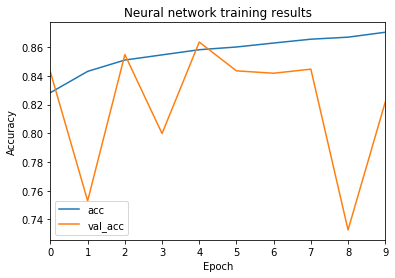

In [0]:
plot_history(cnn)

**Test Set Results:**

In [0]:
cnn_model.evaluate(X_test, y_test_ohe)

55505/55505 [==============================] - 5s 84us/step


[0.39806791648339845, 0.819782001625771]

The baseline CNN with 2 convolutional layers had a test accuracy score of 0.8198 after being trained on the full training set (aside from the portion that got removed from balancing the training set.)

# 3.2
**CNN with data augmentation**

In [0]:
n_classes = 2
input_shape = X_train_rus.shape[1:]
cnn_model_aug = Sequential()

# 1st layer
cnn_model_aug.add(Conv2D(32, kernel_size=(3, 3),
                     input_shape=input_shape))
cnn_model_aug.add(BatchNormalization())
cnn_model_aug.add(Activation("relu"))

cnn_model_aug.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd layer
cnn_model_aug.add(Conv2D(32, (3, 3)))
cnn_model_aug.add(BatchNormalization())
cnn_model_aug.add(Activation("relu"))

cnn_model_aug.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd layer
cnn_model_aug.add(Flatten())
cnn_model_aug.add(Dense(64, activation='relu'))

# output layer, output dimension = number of classes
cnn_model_aug.add(Dense(n_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
cnn_model_aug.compile(optimizer="adam",
                      loss="categorical_crossentropy",
                      metrics=['accuracy'])

In [0]:
train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)


train_generator = train_datagen.flow(X_train_rus,
                                     y_train_rus_ohe,
                                     batch_size=32)


In [0]:
cnn_aug = cnn_model_aug.fit_generator(train_generator,
                                      epochs=10,
                                      steps_per_epoch=len(X_train_rus) / 32,
                                      validation_data=(X_val, y_val_ohe),
                                      validation_steps=len(X_val) / 32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
3546/3545 [==============================] - 99s 28ms/step - loss: 0.4083 - acc: 0.8229 - val_loss: 0.4352 - val_acc: 0.8126
Epoch 2/10
3546/3545 [==============================] - 96s 27ms/step - loss: 0.3743 - acc: 0.8389 - val_loss: 0.8063 - val_acc: 0.5858
Epoch 3/10
3546/3545 [==============================] - 96s 27ms/step - loss: 0.3670 - acc: 0.8437 - val_loss: 0.3448 - val_acc: 0.8474
Epoch 4/10
3546/3545 [==============================] - 93s 26ms/step - loss: 0.3566 - acc: 0.8489 - val_loss: 0.3534 - val_acc: 0.8506
Epoch 5/10
3546/3545 [==============================] - 93s 26ms/step - loss: 0.3540 - acc: 0.8502 - val_loss: 0.4387 - val_acc: 0.8295
Epoch 6/10
3546/3545 [==============================] - 95s 27ms/step - loss: 0.3505 - acc: 0.8523 - val_loss: 0.4099 - val_acc: 0.8219
Epoch 7/10
3546/3545 [==============================] - 94s 27ms/step - loss: 0.3441 - acc: 0.8545 - val_loss: 0.4251 - val_acc: 0.8109


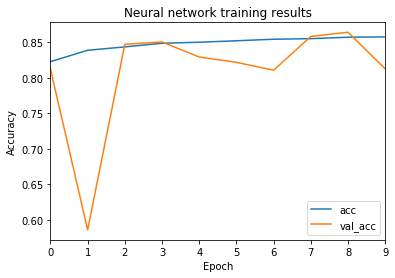

In [0]:
plot_history(cnn_aug)

**Test Set Results:**

In [0]:
cnn_model_aug.evaluate(X_test, y_test_ohe)

55505/55505 [==============================] - 5s 82us/step


[0.4264874572174451, 0.8132240338740441]

In [0]:
# code to reset variables if needed
# del cnn_model_aug, train_datagen, train_generator, cnn_aug

We tried various data augmentation techniques and found that rotation, shifts, mirroring (horizontal/vertical flip), zooming range had better test results sometimes (like on the subsamples) but not on the full training set. The accuracy for the full training set is 0.8132 whereas the baseline without data augmentation was 0.8198. Since the data augmentation didn't improve our results by much, we're not going to use it for part 3.3.

# 3.3

**Deep CNN with residual connections**

In [0]:
num_classes = 2
inputs = Input(shape=(50, 50, 3))

# Set 1
# layer 1
conv1_1 = Conv2D(32, (3, 3),
                 padding='same')(inputs)
conv1_1 = BatchNormalization()(conv1_1)
conv1_1 = Activation("relu")(conv1_1)


# layer 2
conv1_2 = Conv2D(32, (3, 3),
                 padding='same')(conv1_1)
conv1_2 = BatchNormalization()(conv1_2)
conv1_2 = Activation("relu")(conv1_2)


# layer 3
conv1_3 = Conv2D(32, (3, 3),
                 activation='relu',
                 padding='same')(conv1_2)
conv1_3 = BatchNormalization()(conv1_3)
conv1_3 = Activation("relu")(conv1_3)



# add result of layer 1 + result of layer 3
skip1 = add([conv1_1, conv1_3])
maxpool_skip1 = MaxPooling2D(pool_size=(2, 2))(skip1)

# Set 2
# layer 4
conv2_1 = Conv2D(32, (3, 3),
                 padding='same')(maxpool_skip1)
conv2_1 = BatchNormalization()(conv2_1)
conv2_1 = Activation("relu")(conv2_1)


# layer 5
conv2_2 = Conv2D(32, (3, 3),
                 padding='same')(conv2_1)
conv2_2 = BatchNormalization()(conv2_2)
conv2_2 = Activation("relu")(conv2_2)



# skip 2
skip2 = add([maxpool_skip1, conv2_2])
maxpool_skip2 = MaxPooling2D(pool_size=(2, 2))(skip2)

# Set 3
# layer 6
conv3_1 = Conv2D(32, (3, 3),
                 padding='same')(maxpool_skip2)
conv3_1 = BatchNormalization()(conv3_1)
conv3_1 = Activation("relu")(conv3_1)


# layer 7
conv3_2 = Conv2D(32, (3, 3),
                 padding='same')(conv3_1)
conv3_2 = BatchNormalization()(conv3_2)
conv3_2 = Activation("relu")(conv3_2)


# skip 3
skip3 = add([maxpool_skip2, conv3_2])
maxpool_skip3 = MaxPooling2D(pool_size=(2, 2))(skip3)


# Set 4
# layer 8
conv4_1 = Conv2D(32, (3, 3),
                 padding='same')(maxpool_skip3)
conv4_1 = BatchNormalization()(conv4_1)
conv4_1 = Activation("relu")(conv4_1)


# layer 9
conv4_2 = Conv2D(32, (3, 3),
                 padding='same')(conv4_1)
conv4_2 = BatchNormalization()(conv4_2)
conv4_2 = Activation("relu")(conv4_2)


# skip 4
skip4 = add([maxpool_skip3, conv4_2])
maxpool_skip4 = MaxPooling2D(pool_size=(2, 2))(skip4)



# Set 5
# layer 10
conv5_1 = Conv2D(32, (3, 3),
                 padding='same')(maxpool_skip4)
conv5_1 = BatchNormalization()(conv5_1)
conv5_1 = Activation("relu")(conv5_1)


# layer 11
conv5_2 = Conv2D(32, (3, 3),
                 padding='same')(conv5_1)
conv5_2 = BatchNormalization()(conv5_2)
conv5_2 = Activation("relu")(conv5_2)


# skip 5
skip5 = add([maxpool_skip4, conv5_2])
maxpool_skip5 = MaxPooling2D(pool_size=(2, 2))(skip5)



flat = Flatten()(maxpool_skip5)

#layer 12
dense = Dense(64)(flat)
dense = BatchNormalization()(dense)
dense = Activation("relu")(dense)


predictions = Dense(num_classes, activation='softmax')(dense)


model_resnet = Model(inputs=inputs, outputs=predictions)

In [0]:
model_resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 50, 50, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 50, 50, 32)   128         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 50, 50, 32)   0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
conv2d_20 

In [0]:
model_resnet.compile(optimizer="adam",
                      loss="categorical_crossentropy",
                      metrics=['accuracy'])

In [0]:
cnn_resnet = model_resnet.fit(X_train_rus, y_train_rus_ohe,
                              batch_size=32,
                              epochs=20,
                              verbose=1,
                              validation_data=(X_val, y_val_ohe))

Train on 113452 samples, validate on 22202 samples
Epoch 1/20
113452/113452 [==============================] - 95s 834us/step - loss: 0.3785 - acc: 0.8373 - val_loss: 0.3700 - val_acc: 0.8425
Epoch 2/20
113452/113452 [==============================] - 92s 811us/step - loss: 0.3388 - acc: 0.8573 - val_loss: 0.5268 - val_acc: 0.7628
Epoch 3/20
113452/113452 [==============================] - 91s 801us/step - loss: 0.3208 - acc: 0.8664 - val_loss: 0.3094 - val_acc: 0.8683
Epoch 4/20
113452/113452 [==============================] - 179s 2ms/step - loss: 0.3044 - acc: 0.8743 - val_loss: 0.3434 - val_acc: 0.8542
Epoch 5/20
113452/113452 [==============================] - 92s 814us/step - loss: 0.2913 - acc: 0.8805 - val_loss: 0.3663 - val_acc: 0.8521
Epoch 6/20
113452/113452 [==============================] - 91s 802us/step - loss: 0.2842 - acc: 0.8829 - val_loss: 0.3455 - val_acc: 0.8505
Epoch 7/20
113452/113452 [==============================] - 90s 797us/step - loss: 0.2750 - acc: 0.8877 

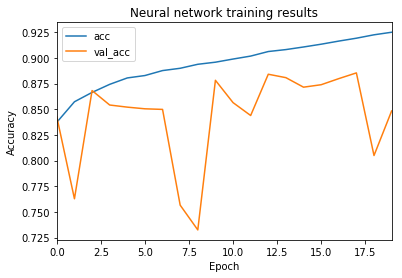

In [0]:
plot_history(cnn_resnet)

**Test Set Results:** 

In [0]:
model_resnet.evaluate(X_test, y_test_ohe)

55505/55505 [==============================] - 9s 169us/step


[0.3817535629992807, 0.8519953157426903]

### Deep CNN without residual connections

In [0]:
num_classes = 2
inputs = Input(shape=(50, 50, 3))

# Set 1
# layer 1
conv1_1 = Conv2D(32, (3, 3),
                 padding='same')(inputs)
conv1_1 = BatchNormalization()(conv1_1)
conv1_1 = Activation("relu")(conv1_1)


# layer 2
conv1_2 = Conv2D(32, (3, 3),
                 padding='same')(conv1_1)
conv1_2 = BatchNormalization()(conv1_2)
conv1_2 = Activation("relu")(conv1_2)


# layer 3
conv1_3 = Conv2D(32, (3, 3),
                 activation='relu',
                 padding='same')(conv1_2)
conv1_3 = BatchNormalization()(conv1_3)
conv1_3 = Activation("relu")(conv1_3)


maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1_3)

# Set 2
# layer 4
conv2_1 = Conv2D(32, (3, 3),
                 padding='same')(maxpool1)
conv2_1 = BatchNormalization()(conv2_1)
conv2_1 = Activation("relu")(conv2_1)


# layer 5
conv2_2 = Conv2D(32, (3, 3),
                 padding='same')(conv2_1)
conv2_2 = BatchNormalization()(conv2_2)
conv2_2 = Activation("relu")(conv2_2)


maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv2_2)


# Set 3
# layer 6
conv3_1 = Conv2D(32, (3, 3),
                 padding='same')(maxpool2)
conv3_1 = BatchNormalization()(conv3_1)
conv3_1 = Activation("relu")(conv3_1)


# layer 7
conv3_2 = Conv2D(32, (3, 3),
                 padding='same')(conv3_1)
conv3_2 = BatchNormalization()(conv3_2)
conv3_2 = Activation("relu")(conv3_2)


maxpool3 = MaxPooling2D(pool_size=(2, 2))(conv3_2)


# Set 4
# layer 8
conv4_1 = Conv2D(32, (3, 3),
                 padding='same')(maxpool3)
conv4_1 = BatchNormalization()(conv4_1)
conv4_1 = Activation("relu")(conv4_1)


# layer 9
conv4_2 = Conv2D(32, (3, 3),
                 padding='same')(conv4_1)
conv4_2 = BatchNormalization()(conv4_2)
conv4_2 = Activation("relu")(conv4_2)


maxpool4 = MaxPooling2D(pool_size=(2, 2))(conv4_2)

# Set 5
# layer 10
conv5_1 = Conv2D(32, (3, 3),
                 padding='same')(maxpool4)
conv5_1 = BatchNormalization()(conv5_1)
conv5_1 = Activation("relu")(conv5_1)


# layer 11
conv5_2 = Conv2D(32, (3, 3),
                 padding='same')(conv5_1)
conv5_2 = BatchNormalization()(conv5_2)
conv5_2 = Activation("relu")(conv5_2)


maxpool5 = MaxPooling2D(pool_size=(2, 2))(conv5_2)


flat = Flatten()(maxpool5)

#layer 12
dense = Dense(64)(flat)
dense = BatchNormalization()(dense)
dense = Activation("relu")(dense)


predictions = Dense(num_classes, activation='softmax')(dense)

model_nores = Model(inputs=inputs, outputs=predictions)

In [0]:
model_nores.compile(optimizer="adam",
                    loss="categorical_crossentropy",
                    metrics=['accuracy'])

In [0]:
cnn_nores = model_nores.fit(X_train_rus, y_train_rus_ohe,
                            batch_size=32,
                            epochs=20,
                            verbose=1,
                            validation_data=(X_val, y_val_ohe))

Train on 113452 samples, validate on 22202 samples
Epoch 1/20
113452/113452 [==============================] - 173s 2ms/step - loss: 0.3882 - acc: 0.8330 - val_loss: 0.6105 - val_acc: 0.7999
Epoch 2/20
113452/113452 [==============================] - 146s 1ms/step - loss: 0.3496 - acc: 0.8520 - val_loss: 0.7707 - val_acc: 0.7834
Epoch 3/20
113452/113452 [==============================] - 89s 785us/step - loss: 0.3308 - acc: 0.8614 - val_loss: 0.3416 - val_acc: 0.8621
Epoch 4/20
113452/113452 [==============================] - 89s 780us/step - loss: 0.3177 - acc: 0.8683 - val_loss: 0.3209 - val_acc: 0.8685
Epoch 5/20
113452/113452 [==============================] - 88s 777us/step - loss: 0.3053 - acc: 0.8733 - val_loss: 0.3162 - val_acc: 0.8670
Epoch 6/20
113452/113452 [==============================] - 178s 2ms/step - loss: 0.2964 - acc: 0.8783 - val_loss: 0.3281 - val_acc: 0.8590
Epoch 7/20
113452/113452 [==============================] - 179s 2ms/step - loss: 0.2893 - acc: 0.8813 - v

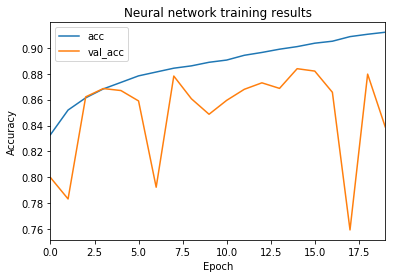

In [0]:
plot_history(cnn_nores)

**Test Set Results:**

In [0]:
model_nores.evaluate(X_test, y_test_ohe)

55505/55505 [==============================] - 43s 775us/step


[0.4049176681316626, 0.8389154130269274]

**Comparing CNN with residual connections and without**

In [0]:
def plot_compare(log_res, log_nores):
    df_res = pd.DataFrame(log_res.history)
    plt.plot(df_res[['val_acc']], label='Residual')
    plt.legend()
    df_nores = pd.DataFrame(log_nores.history)
    plt.plot(df_nores[['val_acc']], label='w/o Residual')
    plt.legend()
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.title("CNN validation results")

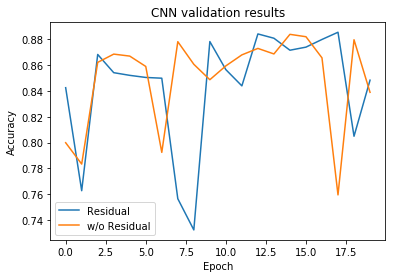

In [0]:
plot_compare(cnn_resnet, cnn_nores)

In comparing the deep CNN with residual connections and without residual connections, in general the residual CNN outperforms the CNN without residuals. Our CNN with residuals (test accuracy: 0.8520) does  better than the CNN without residuals (test accuracy: 0.8389). Both models performed better than our baseline (test accuracy: 0.8198). 

One interesting observation is that the starting validation accuracy for the residual CNN is higher than that of the regular CNN. For both models, the validation accuracy over epochs fluctuates but generally has an increasing trend. 

In addition, we experimented both putting batch normalization before and after relu, and in our case, having batch normalization before relu generates better results. 